In [ ]:
# Imports
import pandas as pd
import numpy as np
import random
random.seed(0)
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage, signal
import glob
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")

## Image Processing

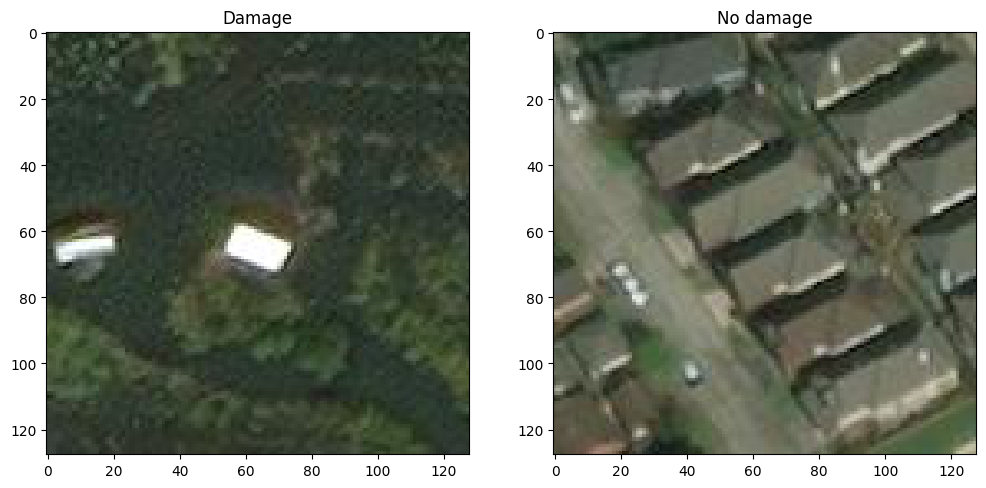

In [ ]:
# Sample images
damage_sample = imread("/content/train_another/damage/-93.65871_30.026395.jpeg")
no_damage_sample = imread("/content/train_another/no_damage/-95.6266_29.860549.jpeg")
plt.figure(figsize=(12, 20))
plt.subplot(121)
plt.imshow(damage_sample)
plt.title("Damage")
plt.subplot(122)
plt.imshow(no_damage_sample)
plt.title("No damage")
plt.show()

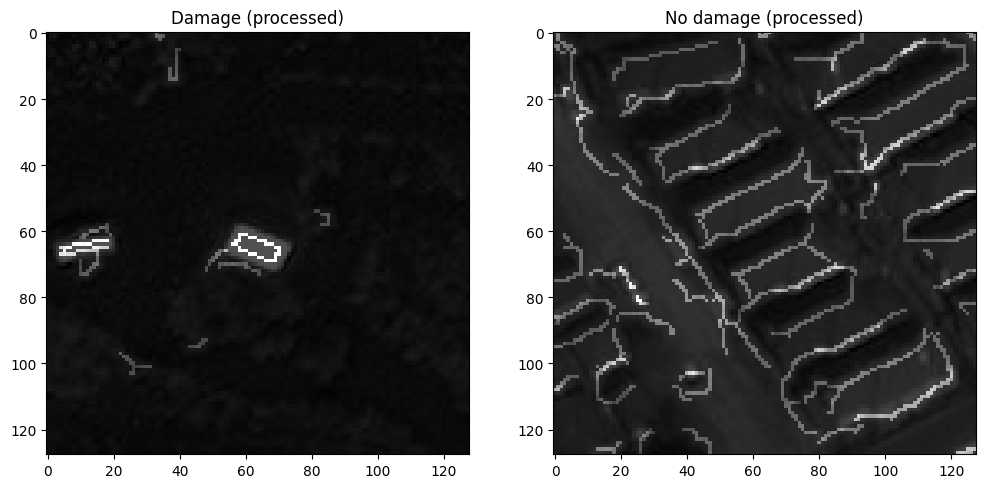

In [ ]:
# Image processing
### Step 1: Guassian blur
### Step 2: Erosion
### Step 3: Edge detection
### Step 4: Edge enhancement

# Function to enhance edges
def process(images, save_dir=None):
    processed_images = []
    for i in range(len(images)):
        # Gaussian blur
        gaussian_img = cv2.GaussianBlur(images[i], (3, 3), 1)
        # Erosion
        kernel = np.ones((3, 3), np.uint8)
        eroded_img = cv2.erode(gaussian_img, kernel, iterations=2)
        # Edge detection
        canny_img = cv2.Canny(eroded_img, 80, 120) - np.ones(shape=(128, 128))
        # Enhance edges
        processed_img = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY) + 0.5*cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)*(canny_img//254)
        processed_images.append(processed_img)
        if save_dir:
            # Save processed image
            cv2.imwrite(os.path.join(save_dir, f'{i+1}.jpeg'), processed_img)
    return processed_images

damage_processed = process([damage_sample], save_dir=None)[0]
no_damage_processed = process([no_damage_sample], save_dir=None)[0]
plt.figure(figsize=(12, 20))
plt.subplot(121)
plt.imshow(damage_processed, cmap="gray")
plt.title("Damage (processed)")
plt.subplot(122)
plt.imshow(no_damage_processed, cmap="gray")
plt.title("No damage (processed)")
plt.show()

In [ ]:
damage = [cv2.imread(file) for file in glob.glob('/content/train_another/damage/*.jpeg')] + [cv2.imread(file) for file in glob.glob('/content/test/damage/*.jpeg')] + [cv2.imread(file) for file in glob.glob('/content/validation_another/damage/*.jpeg')]
no_damage = [cv2.imread(file) for file in glob.glob('/content/train_another/no_damage/*.jpeg')] + [cv2.imread(file) for file in glob.glob('/content/test/no_damage/*.jpeg')] + [cv2.imread(file) for file in glob.glob('/content/validation_another/no_damage/*.jpeg')]

random.shuffle(damage)
random.shuffle(no_damage)

train_damage, test_damage, val_damage = damage[0:5000], damage[5000:6000], damage[6000:7000]
train_no_damage, test_no_damage, val_no_damage = no_damage[0:5000], no_damage[5000:6000], no_damage[6000:7000]

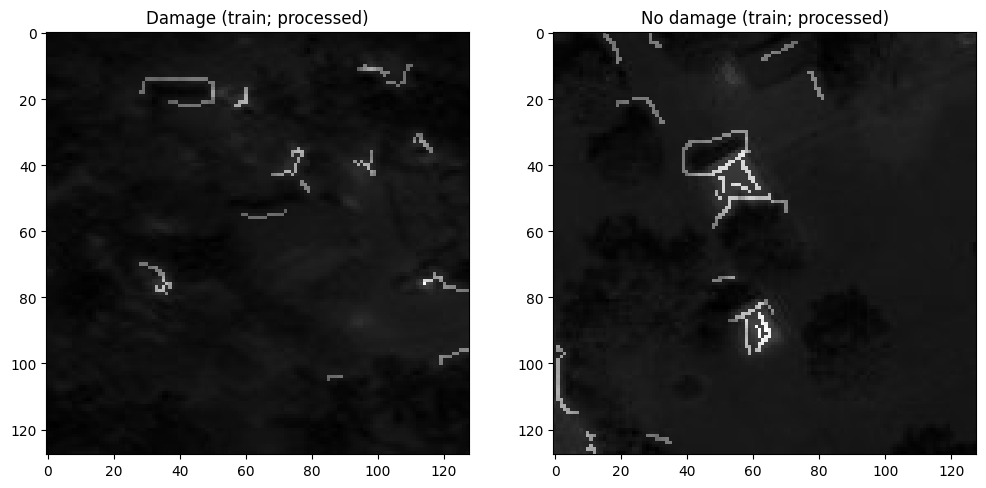

In [ ]:
os.makedirs("/content/train_proc/damage")
os.makedirs("/content/train_proc/no_damage")
train_damage_proc = process(train_damage, save_dir = "/content/train_proc/damage")
train_no_damage_proc = process(train_no_damage, save_dir="/content/train_proc/no_damage")

train_df = pd.DataFrame(columns=["image", "damage"])
train_df.image = [file for file in glob.glob('/content/train_proc/damage/*.jpeg')] + [file for file in glob.glob('/content/train_proc/no_damage/*.jpeg')]
train_df.damage = ["1"]*5000 + ["0"]*5000
train_df = train_df.sample(frac=1).reset_index(drop=True)

plt.figure(figsize=(12, 20))
plt.subplot(121)
plt.imshow(train_damage_proc[10], cmap="gray")
plt.title("Damage (train; processed)")
plt.subplot(122)
plt.imshow(train_no_damage_proc[10], cmap="gray")
plt.title("No damage (train; processed)")
plt.show()

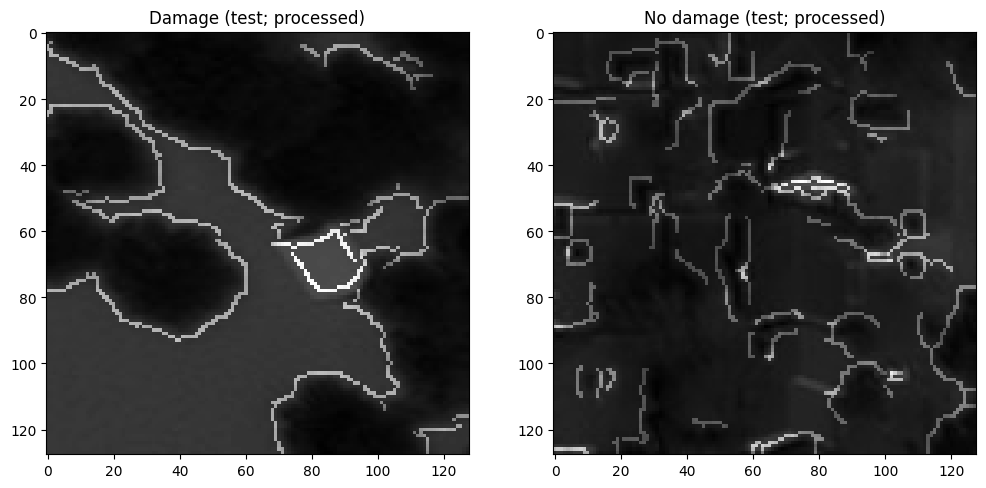

In [ ]:
os.makedirs("/content/test_proc/damage")
os.makedirs("/content/test_proc/no_damage")
test_damage_proc = process(test_damage, save_dir = "/content/test_proc/damage")
test_no_damage_proc = process(test_no_damage, save_dir = "/content/test_proc/no_damage")

test_df = pd.DataFrame(columns=["image", "damage"])
test_df.image = [file for file in glob.glob('/content/test_proc/damage/*.jpeg')] + [file for file in glob.glob('/content/test_proc/no_damage/*.jpeg')]
test_df.damage = ["1"]*1000 + ["0"]*1000
test_df = test_df.sample(frac=1).reset_index(drop=True)

plt.figure(figsize=(12, 20))
plt.subplot(121)
plt.imshow(test_damage_proc[10], cmap="gray")
plt.title("Damage (test; processed)")
plt.subplot(122)
plt.imshow(test_no_damage_proc[10], cmap="gray")
plt.title("No damage (test; processed)")
plt.show()

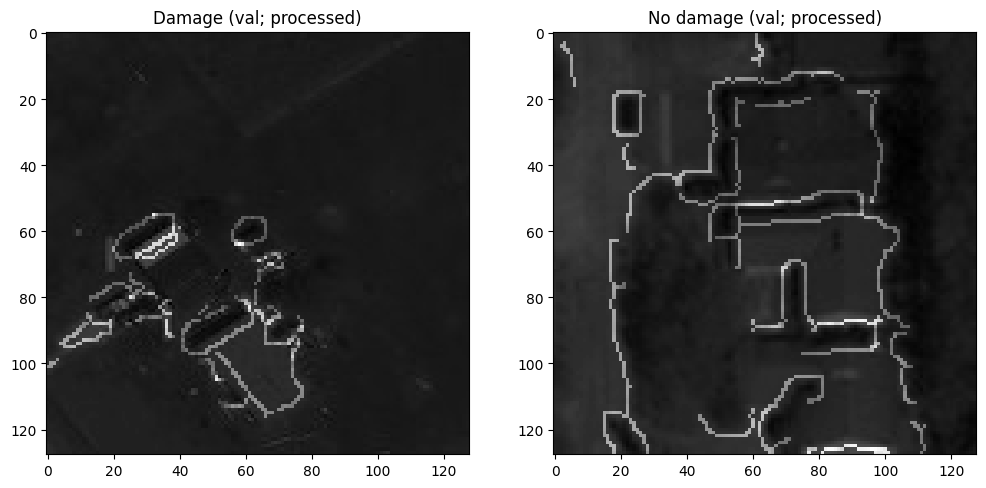

In [ ]:
os.makedirs("/content/val_proc/damage")
os.makedirs("/content/val_proc/no_damage")
val_damage_proc = process(val_damage, save_dir = "/content/val_proc/damage")
val_no_damage_proc = process(val_no_damage, save_dir = "/content/val_proc/no_damage")

val_df = pd.DataFrame(columns=["image", "damage"])
val_df.image = [file for file in glob.glob('/content/val_proc/damage/*.jpeg')] + [file for file in glob.glob('/content/val_proc/no_damage/*.jpeg')]
val_df.damage = ["1"]*1000 + ["0"]*1000
val_df = val_df.sample(frac=1).reset_index(drop=True)

plt.figure(figsize=(12, 20))
plt.subplot(121)
plt.imshow(val_damage_proc[10], cmap="gray")
plt.title("Damage (val; processed)")
plt.subplot(122)
plt.imshow(val_no_damage_proc[10], cmap="gray")
plt.title("No damage (val; processed)")
plt.show()

## Custom CNN

In [ ]:
train_data_gen = ImageDataGenerator(horizontal_flip=True)
train_data = train_data_gen.flow_from_dataframe(
    dataframe = train_df,
    x_col = "image",
    y_col = "damage",
    target_size = (128, 128),
    color_mode = "grayscale",
    class_mode = "binary",
    shuffle = False,
    subset = "training",
    batch_size = 100
)

test_data_gen = ImageDataGenerator(horizontal_flip=True)
test_data = test_data_gen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "image",
    y_col = "damage",
    target_size = (128, 128),
    color_mode = "grayscale",
    class_mode = "binary",
    shuffle = False,
    batch_size = 100
)

val_data_gen = ImageDataGenerator(horizontal_flip=True)
val_data = val_data_gen.flow_from_dataframe(
    dataframe = val_df,
    x_col = "image",
    y_col = "damage",
    target_size = (128, 128),
    color_mode = "grayscale",
    class_mode = "binary",
    shuffle = False,
    batch_size = 100
)

Found 10000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', input_shape=(128, 128, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = tf.optimizers.SGD(learning_rate=0.0001, momentum=0.8),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 64)      1664      
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 128)     204928    
                                                                 
 batch_normalization_1 (Batc  (None, 120, 120, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 128)      0         
 )                                                               
                                                        

In [ ]:
# plot_model(model, to_file="harveynet4.png", show_shapes=True)

In [ ]:
history = model.fit(train_data, epochs=50, validation_data=val_data)

Epoch 1/50
100/100 [==============================] - 74s 536ms/step - loss: 0.8068 - accuracy: 0.7113 - val_loss: 0.4804 - val_accuracy: 0.7945
Epoch 2/50
100/100 [==============================] - 54s 539ms/step - loss: 0.5812 - accuracy: 0.7788 - val_loss: 0.3947 - val_accuracy: 0.8355
Epoch 3/50
100/100 [==============================] - 55s 546ms/step - loss: 0.4945 - accuracy: 0.8039 - val_loss: 0.3567 - val_accuracy: 0.8520
Epoch 4/50
100/100 [==============================] - 55s 549ms/step - loss: 0.4522 - accuracy: 0.8221 - val_loss: 0.3202 - val_accuracy: 0.8625
Epoch 5/50
100/100 [==============================] - 55s 546ms/step - loss: 0.4161 - accuracy: 0.8330 - val_loss: 0.2929 - val_accuracy: 0.8760
Epoch 6/50
100/100 [==============================] - 55s 550ms/step - loss: 0.3919 - accuracy: 0.8380 - val_loss: 0.2768 - val_accuracy: 0.8845
Epoch 7/50
100/100 [==============================] - 55s 553ms/step - loss: 0.3666 - accuracy: 0.8479 - val_loss: 0.2756 - val_ac

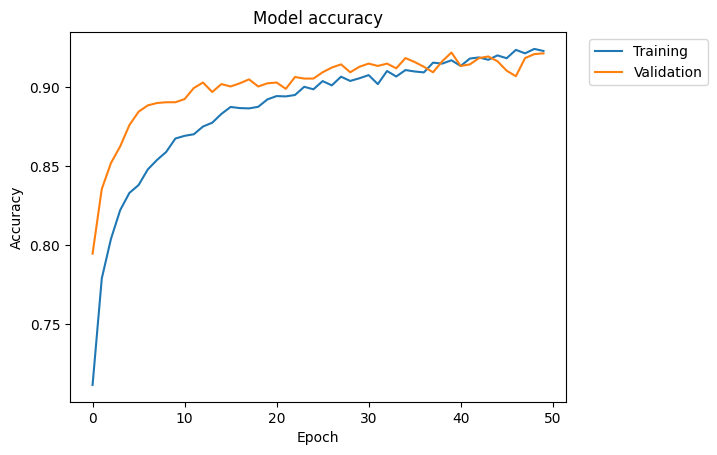

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

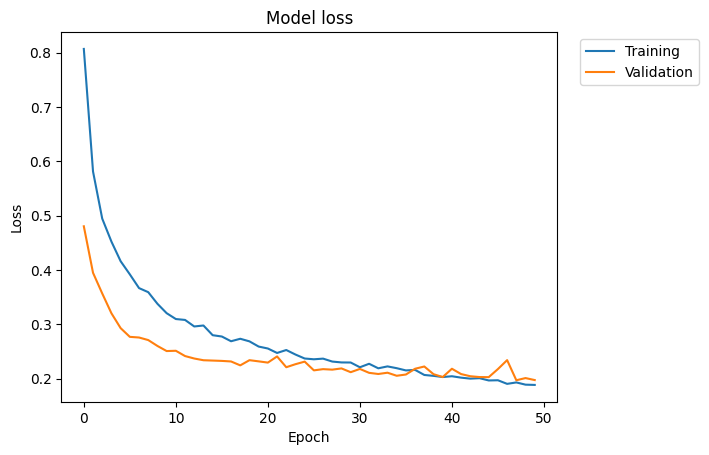

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

In [ ]:
model.evaluate(test_data)

20/20 [==============================] - 2s 106ms/step - loss: 0.1908 - accuracy: 0.9290


[0.1907878965139389, 0.9290000200271606]

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# model.save('/content/drive/MyDrive/harveynet4.h5')

In [ ]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/AI 2/harveynet4.h5')

100/100 [==============================] - 11s 107ms/step


<Axes: >

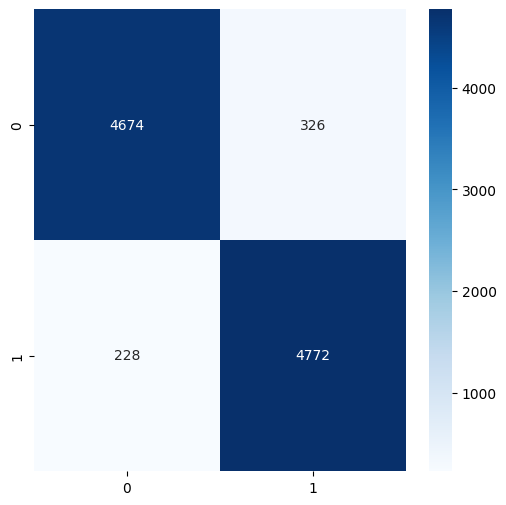

In [ ]:
ytrain_pred = np.round(model.predict(train_data))
ytrain_true = train_data.classes
train_cm = confusion_matrix(ytrain_true, ytrain_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap="Blues")

In [ ]:
print("Train accuracy:", round(accuracy_score(ytrain_true, ytrain_pred), 3))
print("Train F1 score:", round(f1_score(ytrain_true, ytrain_pred), 3))
print("Train precision:", round(precision_score(ytrain_true, ytrain_pred), 3))
print("Train recall:", round(recall_score(ytrain_true, ytrain_pred), 3))

Train accuracy: 0.945
Train F1 score: 0.945
Train precision: 0.936
Train recall: 0.954


<Axes: >

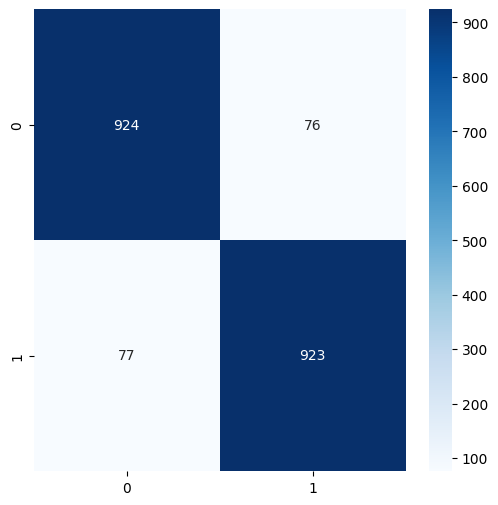

In [ ]:
yval_pred = np.round(model.predict_generator(val_data))
yval_true = val_data.classes
val_cm = confusion_matrix(yval_true, yval_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(val_cm, annot=True, fmt='d', cmap="Blues")

In [ ]:
print("Validation accuracy:", round(accuracy_score(yval_true, yval_pred), 3))
print("Validation F1 score:", round(f1_score(yval_true, yval_pred), 3))
print("Validation precision:", round(precision_score(yval_true, yval_pred), 3))
print("Validation recall:", round(recall_score(yval_true, yval_pred), 3))

Validation accuracy: 0.924
Validation F1 score: 0.923
Validation precision: 0.924
Validation recall: 0.923


<Axes: >

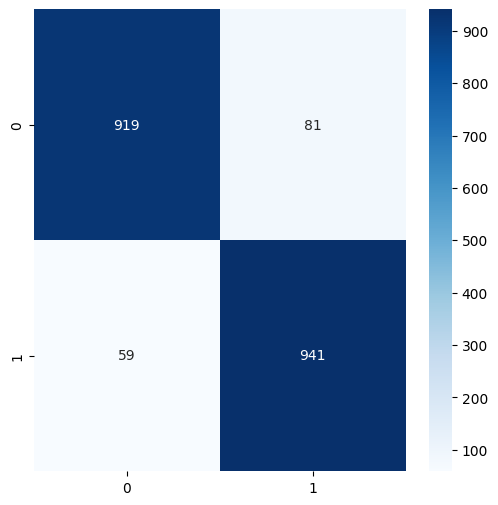

In [ ]:
ytest_pred = np.round(model.predict_generator(test_data))
ytest_true = test_data.classes
test_cm = confusion_matrix(ytest_true, ytest_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap="Blues")

In [ ]:
print("Test accuracy:", round(accuracy_score(ytest_true, ytest_pred), 3))
print("Test F1 score:", round(f1_score(ytest_true, ytest_pred), 3))
print("Test precision:", round(precision_score(ytest_true, ytest_pred), 3))
print("Test recall:", round(recall_score(ytest_true, ytest_pred), 3))

Test accuracy: 0.93
Test F1 score: 0.931
Test precision: 0.921
Test recall: 0.941
